# 🧠 OASIS – EDA de Cortes Coronales (V2)
### Exploración estructural para detectar diferencias entre CN, MCI y AD

**⚠️ IMPORTANTE: Este notebook asume que las imágenes ya han sido estandarizadas por el notebook 3.5**
- Las imágenes deben estar en formato PNG, tamaño 224×224, y normalizadas con z-score
- Si no has ejecutado el notebook 3.5, hazlo primero

Este notebook analiza imágenes coronales **estandarizadas** del dataset OASIS, clasificadas por:
- **CN**: Cognitively Normal
- **MCI**: Mild Cognitive Impairment
- **AD**: Alzheimer

## 🎯 Objetivo general
Realizar un EDA profundo que permita observar:
1. **Patrones globales de intensidad** entre clases.
2. **Variaciones regionales** mediante una grilla espacial.
3. **Pérdida de volumen o masa cerebral** mediante perfiles estructurales.
4. **Diferencias anatómicas específicas** por voxel.
5. **Cambios en bordes estructurales** (indicadores de atrofia).
6. **Differences espacial (varianza)** que indiquen regiones inestables o degeneradas.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.decomposition import PCA
from scipy import ndimage

BASE_DIR = r"C:\\Users\\mmera\\OneDrive\\Escritorio\\ProyectoMineria\\proyectoMineria"
CORONAL_DIR = os.path.join(BASE_DIR, 'data', 'processed', 'OASIS_2D')

classes = ['CN', 'MCI', 'AD']
# Buscar imágenes en múltiples formatos (PNG, JPG, JPEG) para incluir imágenes de Kaggle
images_paths = {}
for c in classes:
    all_images = []
    for ext in ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG', '*.JPEG']:
        all_images.extend(glob(os.path.join(CORONAL_DIR, c, ext)))
    images_paths[c] = sorted(all_images)

for c in classes:
    print(f"{c}: {len(images_paths[c])} imágenes")

CN: 350 imágenes
MCI: 198 imágenes
AD: 48 imágenes


## 1. Cargar imágenes estandarizadas (submuestra controlada)
Cargamos hasta 200 imágenes por clase para evitar sobrecargar memoria.

**Nota:** Las imágenes ya están estandarizadas (224×224, normalizadas) por el notebook 3.5.

*Qué buscamos aquí:* verificar tamaños, distribución y consistencia del dataset estandarizado.

In [2]:
MAX_PER_CLASS = 200

def load_images(paths, max_n=None):
    imgs = []
    for p in paths[:max_n]:
        imgs.append(np.array(Image.open(p).convert('L'), dtype=np.float32))
    return np.stack(imgs, axis=0) if imgs else None

data = {c: load_images(images_paths[c], MAX_PER_CLASS) for c in classes}
for c in classes:
    print(c, None if data[c] is None else data[c].shape)

CN (200, 256, 128)
MCI (198, 256, 128)
AD (48, 256, 128)


## 2. Ejemplos visuales
*Qué buscamos:* diferencias visibles en estructura general, atrofia, tamaño de ventrículos.

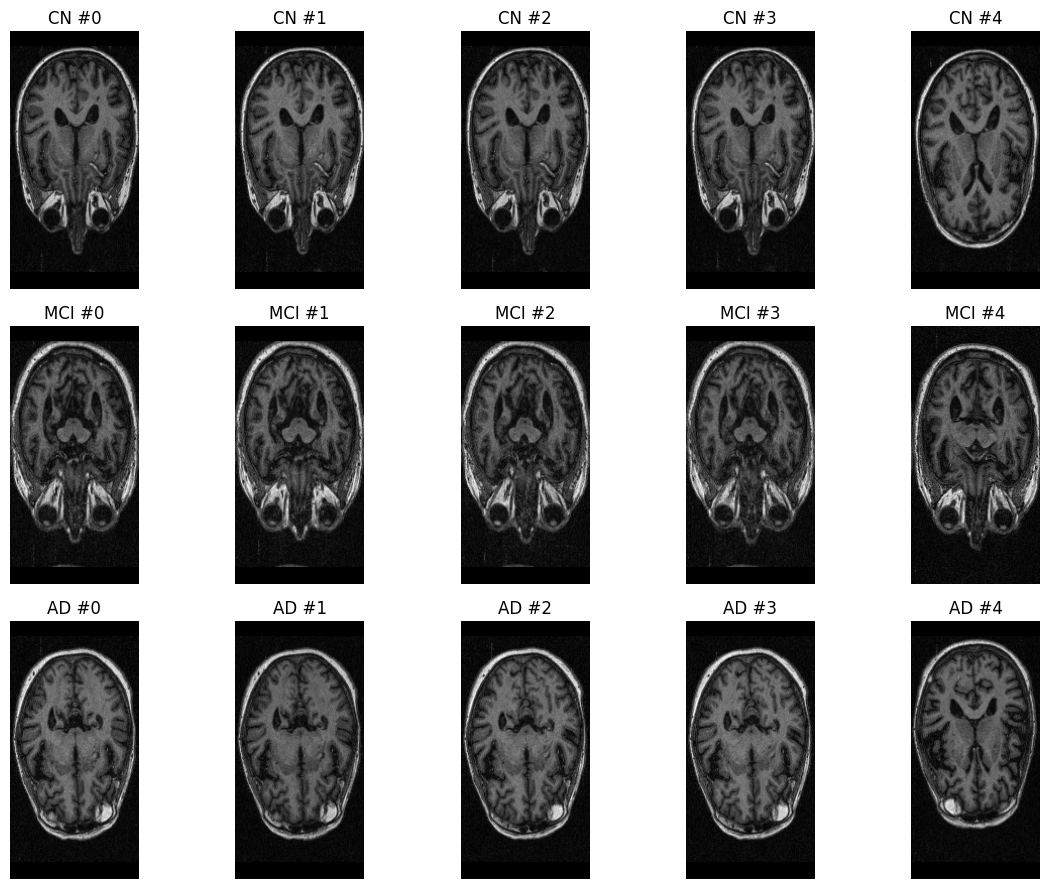

In [3]:
fig, axes = plt.subplots(len(classes), 5, figsize=(12, 3*len(classes)))
for i, c in enumerate(classes):
    if data[c] is None: continue
    for j in range(5):
        axes[i, j].imshow(data[c][j], cmap='gray')
        axes[i, j].set_title(f"{c} #{j}")
        axes[i, j].axis('off')
plt.tight_layout(); plt.show()

## 3. Distribuciones globales de intensidad
Queremos ver si AD muestra perfiles más oscuros (atrofia → menor masa → menor intensidad promedio).

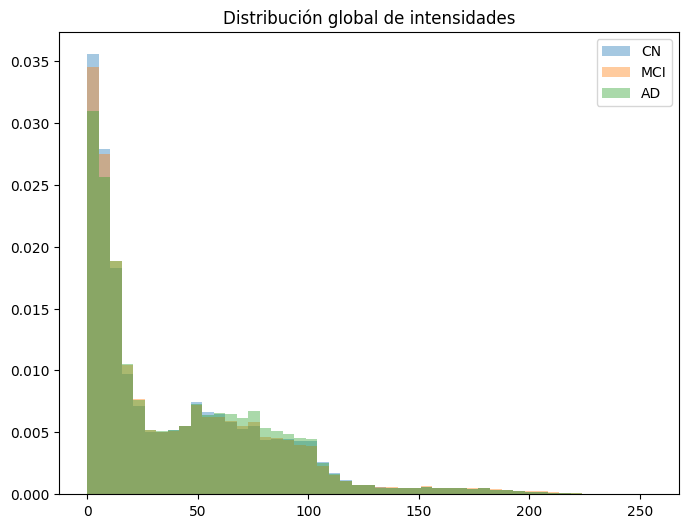

In [4]:
plt.figure(figsize=(8,6))
bins = np.linspace(0, 255, 50)
for c in classes:
    if data[c] is None: continue
    plt.hist(data[c].ravel(), bins=bins, alpha=0.4, label=c, density=True)
plt.legend(); plt.title('Distribución global de intensidades'); plt.show()

## 4. Grilla por secciones (análisis regional)
Dividimos en una grilla 16×16 y analizamos el promedio por región.
*Qué buscamos:* zonas donde AD tiene menor intensidad → regiones afectadas anatómicamente.

### 🎨 Leyenda de Colores (Mapa de Calor - Colormap 'magma')

El mapa de calor muestra la **intensidad promedio** de cada región de la grilla:

- **🟣 Negro/Violeta oscuro**: Intensidades muy bajas (0-20)
  - Regiones con poco tejido cerebral
  - Espacios vacíos, bordes de la imagen
  - Posibles áreas de atrofia severa

- **🔴 Rojo**: Intensidades medias-bajas (20-60)
  - Materia gris del cerebro
  - Regiones con tejido cerebral normal

- **🟡 Amarillo**: Intensidades medias-altas (60-100)
  - Materia blanca del cerebro
  - Regiones con mayor densidad de tejido

- **⚪ Blanco/Amarillo claro**: Intensidades muy altas (100-255)
  - Líquido cefalorraquídeo (LCR)
  - Ventrículos expandidos
  - Regiones con mucho líquido

**Interpretación**: 
- Si AD muestra más regiones oscuras (negro/violeta) que CN → indica atrofia (pérdida de tejido)
- Si AD muestra más regiones claras (blanco) en el centro → indica expansión ventricular

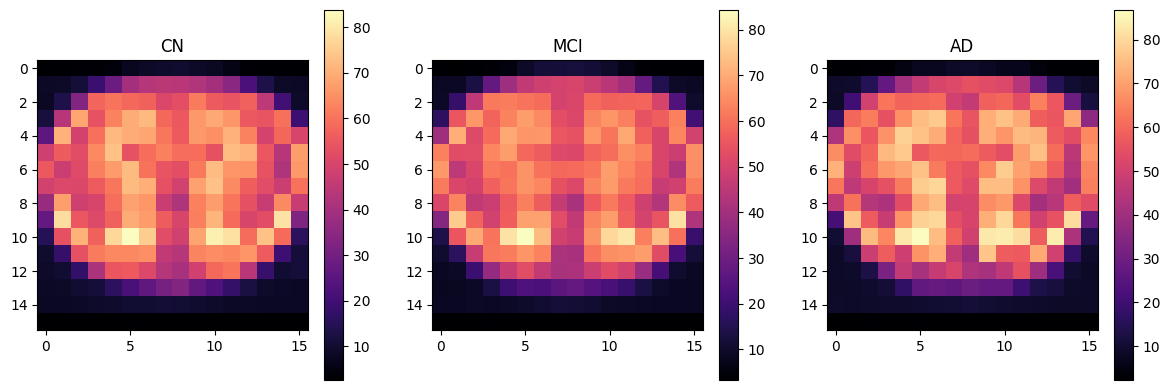

In [6]:
GRID_X, GRID_Y = 16, 16

def grid_means(imgs):
    if imgs is None: return None
    N, H, W = imgs.shape
    hx, wx = H//GRID_X, W//GRID_Y
    grid = np.zeros((GRID_X, GRID_Y))
    for i in range(GRID_X):
        for j in range(GRID_Y):
            grid[i,j] = imgs[:, i*hx:(i+1)*hx, j*wx:(j+1)*wx].mean()
    return grid

grid_maps = {c: grid_means(data[c]) for c in classes}

fig, axes = plt.subplots(1, len(classes), figsize=(12,4))
for i, c in enumerate(classes):
    im = axes[i].imshow(grid_maps[c], cmap='magma')
    axes[i].set_title(f'{c}')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout(); plt.show()

## 5. Diferencias regionales (MCI−CN, AD−CN)
*Qué buscamos:* evidencia espacial del deterioro tempranamente localizado.

### 🎨 Leyenda de Colores (Mapa de Diferencias - Colormap 'bwr' = Blue-White-Red)

El mapa muestra las **diferencias directas** entre clases (MCI - CN o AD - CN):

- **🔵 Azul intenso**: Valores muy negativos (diferencias grandes negativas)
  - La clase comparada (MCI/AD) tiene **menor intensidad** que CN
  - **Interpretación**: Pérdida de tejido cerebral, atrofia, espacios vacíos
  - **Ejemplo**: Si AD tiene más azul → AD tiene menos tejido que CN (atrofia)

- **🔵 Azul claro**: Valores negativos moderados
  - Disminución moderada de intensidad
  - Ligera pérdida de tejido

- **⚪ Blanco**: Valores cercanos a cero
  - **Sin diferencias significativas** entre las clases
  - Regiones preservadas, sin cambios aparentes

- **🔴 Rojo claro**: Valores positivos moderados
  - Aumento moderado de intensidad
  - Ligera expansión de estructuras

- **🔴 Rojo intenso**: Valores muy positivos (diferencias grandes positivas)
  - La clase comparada (MCI/AD) tiene **mayor intensidad** que CN
  - **Interpretación**: Más líquido cefalorraquídeo, ventrículos expandidos
  - **Ejemplo**: Si AD tiene más rojo en el centro → ventrículos más grandes que CN

**Resumen visual**:
- **Azul = Menos tejido** (atrofia, pérdida de masa cerebral)
- **Blanco = Sin cambios** (regiones preservadas)
- **Rojo = Más líquido** (expansión ventricular, más LCR)

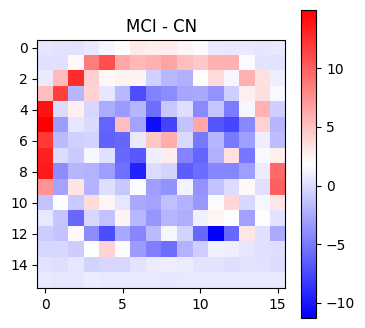

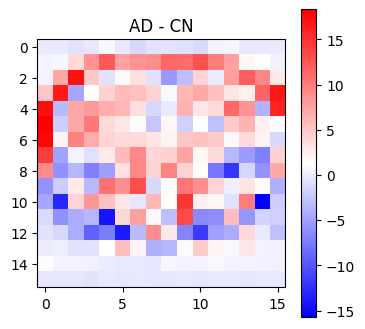

In [7]:
def plot_diff(a, b, title):
    diff = b - a
    plt.figure(figsize=(4,4))
    im = plt.imshow(diff, cmap='bwr')
    plt.title(title)
    plt.colorbar(im)
    plt.show()

plot_diff(grid_maps['CN'], grid_maps['MCI'], 'MCI - CN')
plot_diff(grid_maps['CN'], grid_maps['AD'], 'AD - CN')

## 6. Perfiles de intensidad por columnas y filas
*Qué buscamos:* cambios en hemisferios o regiones inferiores (temporal medial, hipocampo).

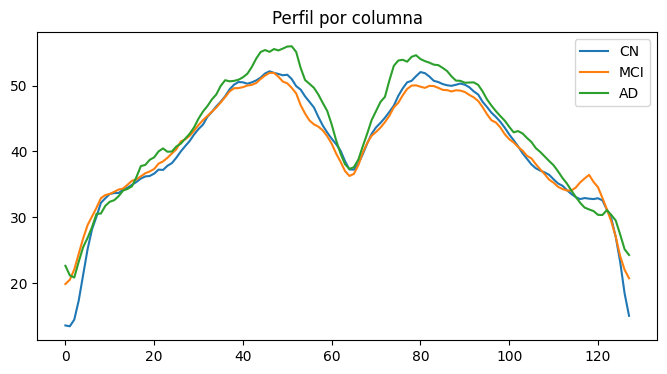

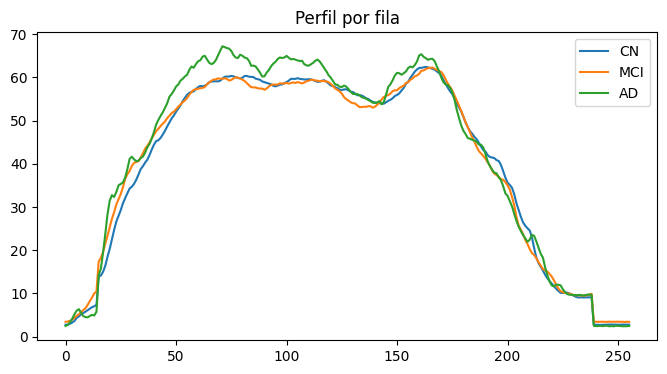

In [8]:
profiles_cols = {}
profiles_rows = {}

for c in classes:
    if data[c] is None: continue
    mean_img = data[c].mean(axis=0)
    profiles_cols[c] = mean_img.mean(axis=0)
    profiles_rows[c] = mean_img.mean(axis=1)

plt.figure(figsize=(8,4))
for c in classes:
    if c in profiles_cols: plt.plot(profiles_cols[c], label=c)
plt.legend(); plt.title('Perfil por columna'); plt.show()

plt.figure(figsize=(8,4))
for c in classes:
    if c in profiles_rows: plt.plot(profiles_rows[c], label=c)
plt.legend(); plt.title('Perfil por fila'); plt.show()

## 7. Imagen promedio por clase y diferencias voxel a voxel
*Qué buscamos:* patrones anatómicos medios → AD debería mostrar regiones con menor intensidad.

### 🎨 Leyenda de Colores

#### Imágenes Promedio (Colormap 'gray'):
- **⚫ Negro (0)**: Ausencia de señal, espacios vacíos, fondo
- **⚪ Gris oscuro (0-85)**: Tejido denso, materia gris
- **⚪ Gris medio (85-170)**: Materia blanca, tejido cerebral normal
- **⚪ Gris claro/Blanco (170-255)**: Líquido cefalorraquídeo, ventrículos

#### Mapas de Diferencia Voxel a Voxel (Colormap 'bwr'):
- **🔵 Azul**: AD/MCI tiene **menor intensidad** que CN en ese píxel
  - Indica **atrofia** o **pérdida de tejido** en esa ubicación exacta
  - Cuanto más azul = mayor pérdida de tejido
  
- **⚪ Blanco**: Sin diferencias entre clases en ese píxel
  - Regiones donde las clases son similares
  
- **🔴 Rojo**: AD/MCI tiene **mayor intensidad** que CN en ese píxel
  - Indica **expansión** de ventrículos o **más líquido** en esa ubicación
  - Cuanto más rojo = mayor expansión/expansión ventricular

**Interpretación anatómica**:
- **Patrones azules en corteza**: Atrofia cortical (pérdida de materia gris)
- **Patrones rojos en centro**: Expansión ventricular (más LCR)
- **Patrones coherentes**: Los cambios forman estructuras anatómicas reconocibles

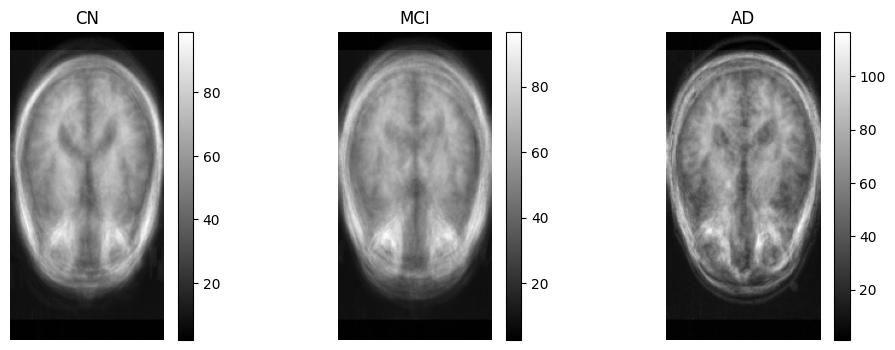

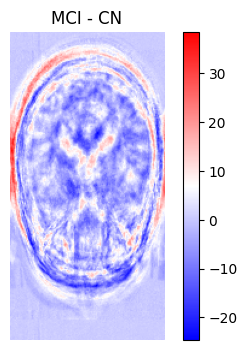

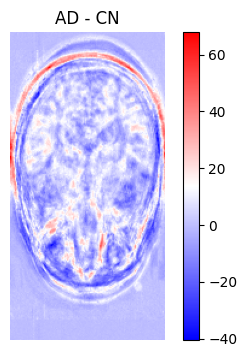

In [9]:
mean_imgs = {c: data[c].mean(axis=0) for c in classes}

fig, axes = plt.subplots(1, 3, figsize=(12,4))
for i,c in enumerate(classes):
    im = axes[i].imshow(mean_imgs[c], cmap='gray')
    axes[i].set_title(c)
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i])
plt.show()

def show_diff(a, b, title):
    diff = b - a
    plt.figure(figsize=(5,4))
    im = plt.imshow(diff, cmap='bwr')
    plt.title(title)
    plt.colorbar(im)
    plt.axis('off')
    plt.show()

show_diff(mean_imgs['CN'], mean_imgs['MCI'], 'MCI - CN')
show_diff(mean_imgs['CN'], mean_imgs['AD'], 'AD - CN')

## 8. Edge Detection (Sobel)
*Objetivo:* detectar pérdida de bordes estructurales, indicador de atrofia.

### 🎨 Leyenda de Colores (Detección de Bordes - Colormap 'inferno')

El mapa muestra la **magnitud de los bordes** detectados en las imágenes (cambios bruscos de intensidad):

- **⚫ Negro/Violeta oscuro**: Sin bordes detectados (0)
  - Regiones homogéneas, sin cambios bruscos
  - Espacios uniformes, sin estructuras definidas

- **🔵 Azul**: Bordes débiles
  - Transiciones suaves entre estructuras
  - Bordes poco definidos

- **🟢 Verde**: Bordes moderados
  - Transiciones moderadas entre tejidos
  - Estructuras con definición media

- **🟡 Amarillo**: Bordes fuertes
  - Cambios bruscos de intensidad
  - Límites bien definidos entre estructuras (ej: cerebro-LCR, materia gris-blanca)

- **🔴 Rojo/Blanco**: Bordes muy fuertes
  - Transiciones muy marcadas
  - Límites anatómicos muy definidos (ventrículos, superficie cerebral)

**Interpretación clínica**:
- **Menos bordes en AD**: Indica pérdida de definición estructural → **atrofia**
- **Bordes más difusos**: Los límites entre estructuras se vuelven menos claros
- **Pérdida de contraste**: La atrofia hace que las transiciones sean más suaves
- **Comparación entre clases**: 
  - CN debería tener bordes más definidos (más amarillo/rojo)
  - AD debería tener menos bordes fuertes (más azul/negro) → atrofia

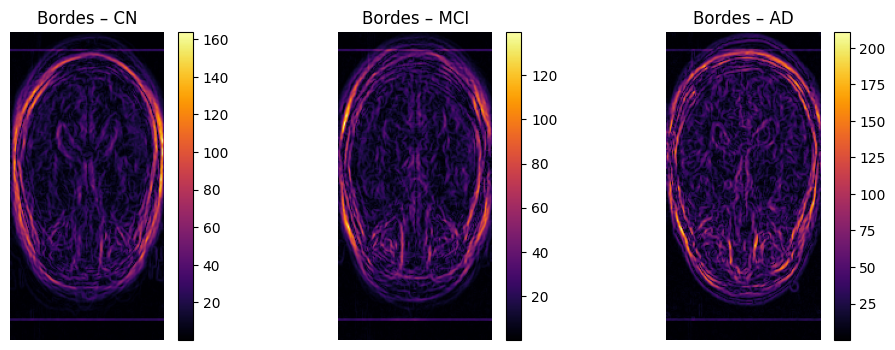

In [10]:
def sobel_edges(img):
    sx = ndimage.sobel(img, axis=0)
    sy = ndimage.sobel(img, axis=1)
    return np.hypot(sx, sy)

edge_maps = {c: sobel_edges(mean_imgs[c]) for c in classes}

fig, axes = plt.subplots(1,3, figsize=(12,4))
for i,c in enumerate(classes):
    im = axes[i].imshow(edge_maps[c], cmap='inferno')
    axes[i].set_title(f'Bordes – {c}')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i])
plt.show()

## 9. Spatial Variance Map
*Objetivo:* detectar regiones con mayor variabilidad entre sujetos → zonas que cambian más en MCI/AD.

### 🎨 Leyenda de Colores (Mapa de Varianza Espacial - Colormap 'viridis')

El mapa muestra la **variabilidad** (varianza) de intensidades entre diferentes sujetos de la misma clase en cada posición espacial:

- **⚫ Negro/Violeta oscuro**: Varianza muy baja (0)
  - Regiones **muy consistentes** entre sujetos
  - Todas las imágenes tienen valores similares en esa posición
  - Estructuras anatómicas estables y predecibles

- **🔵 Azul**: Varianza baja
  - Regiones relativamente consistentes
  - Poca variación entre sujetos

- **🟢 Verde**: Varianza moderada
  - Variabilidad intermedia
  - Algunas diferencias entre sujetos, pero dentro de rangos normales

- **🟡 Amarillo**: Varianza alta
  - **Alta variabilidad** entre sujetos
  - Regiones donde diferentes pacientes tienen valores muy distintos
  - Puede indicar estructuras que varían mucho entre individuos

- **⚪ Amarillo claro/Blanco**: Varianza muy alta
  - **Variabilidad extrema** entre sujetos
  - Regiones muy inestables o inconsistentes
  - Puede indicar:
    - Zonas afectadas de manera diferente en cada paciente
    - Regiones donde la enfermedad progresa de forma variable
    - Áreas con artefactos o problemas de alineación

**Interpretación clínica**:
- **Mayor varianza en AD/MCI**: Indica que la enfermedad afecta a diferentes pacientes de manera distinta
- **Regiones con alta varianza**: Pueden ser zonas donde la enfermedad progresa de forma más variable
- **Regiones con baja varianza**: Estructuras preservadas o afectadas de manera consistente
- **Comparación entre clases**:
  - Si AD tiene más regiones amarillas/blancas → mayor heterogeneidad en cómo afecta la enfermedad
  - Si CN tiene más regiones oscuras → estructuras más consistentes en sujetos normales

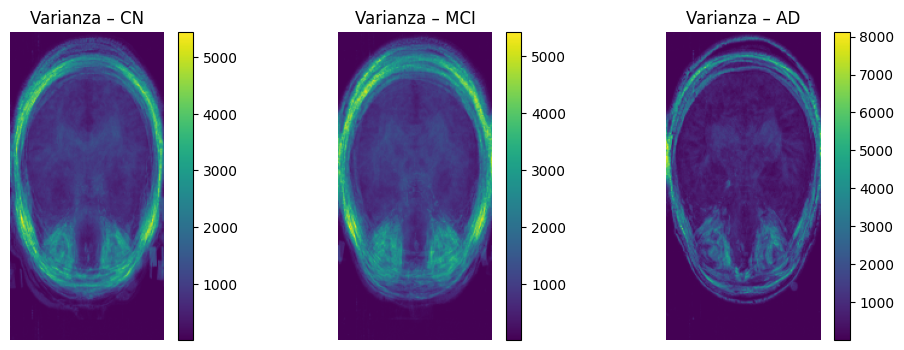

In [11]:
variance_maps = {c: np.var(data[c], axis=0) for c in classes}

fig, axes = plt.subplots(1,3, figsize=(12,4))
for i,c in enumerate(classes):
    im = axes[i].imshow(variance_maps[c], cmap='viridis')
    axes[i].set_title(f'Varianza – {c}')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i])
plt.show()

## 10. PCA espacial
*Objetivo:* ver separabilidad entre clases en un espacio reducido.

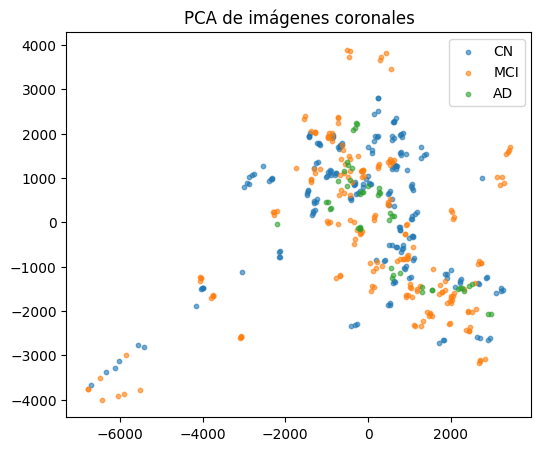

In [12]:
X = []; y = []
for c in classes:
    X.append(data[c].reshape(data[c].shape[0], -1))
    y += [c]*data[c].shape[0]

X = np.vstack(X)
pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(6,5))
for c,color in zip(classes,['b','orange','g']):
    idx = [i for i,v in enumerate(y) if v==c]
    plt.scatter(pca[idx,0], pca[idx,1], s=10, label=c, alpha=0.6)

plt.legend(); plt.title('PCA de imágenes coronales'); plt.show()